# Stochastic Volatility Models

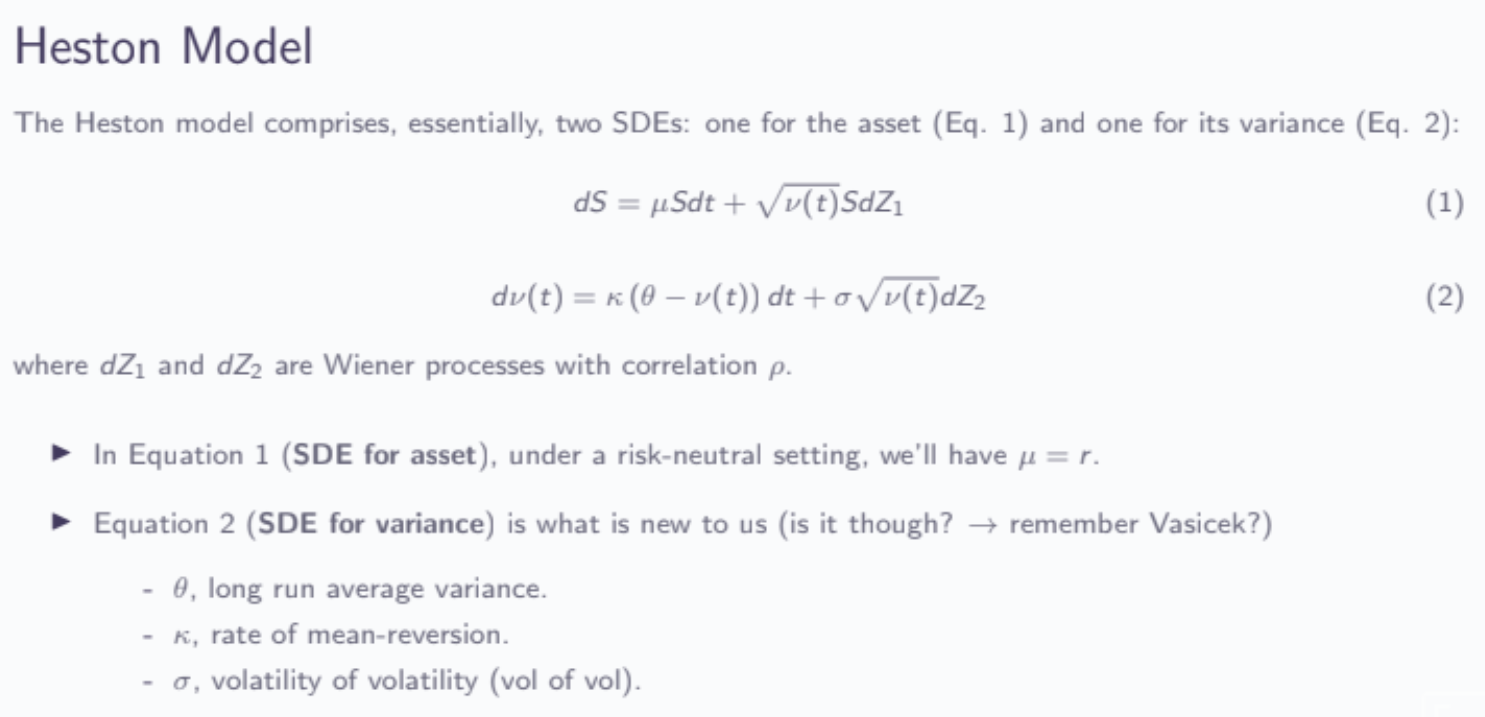

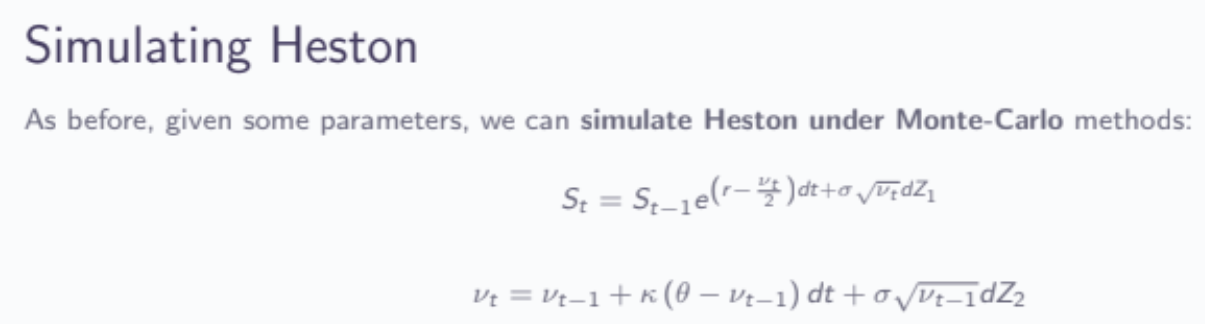

$$
\Large\begin{equation*} 
    S_t = S_{t-1} e^{\left( r - \frac{\nu_t}{2} \right) dt + \sqrt{\nu_t} dZ_1}
\end{equation*} 
$$
$$
\Large\begin{equation*} 
    \nu_t = \nu_{t-1} + \kappa \left( \theta - \nu_{t-1} \right) dt + \sigma \sqrt{\nu_{t-1}}dZ_2
\end{equation*}
$$

where,

$\theta:$ long-term average variance

$\kappa:$ rate of mean-reversion of the variance

$\sigma:$ volatility of the variance process

# My Try

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

def gen_dZ(rho, n, T):
    """Generates correlated standard brownian motions dZ1 and dZ2

    Args:
        rho (float): correlation between the "asset brownian motion" dZ1
                    and the "variance brownian motion" dZ2
        n (int): number of timesteps
    """
    dt = T/n
    
    # dZ1 ~ N(0, dt)
    dZ1 = np.random.standard_normal(n) * np.sqrt(dt)  # create the first brownian motion elements, for asset price process
    temp_arr = np.random.standard_normal(n)  # draw independent standard gaussians to use for correlated random variables
    dZ2 = rho * dZ1 + np.sqrt(1 - rho**2) * temp_arr * np.sqrt(dt)  # create the second brownian motion elements, for variance process
    return dZ1, dZ2

def v(v0, kappa, theta, sigma, n, T, dZ2):
    """Calculates the variance process

    Args:
        v0 (float): initial variance value to start from
        kappa (float): parameter for the speed of mean-reversion
        theta (float): long term average of the variance
        dt (float): length of timestep
        sigma (float): volatility of the variance process
        rho (float): correlation between the "asset brownian motion" dZ1
                    and the "variance brownian motion" dZ2
        n (int): number of timesteps to simulate
        T (float): Time at the end of the process to be simulated (maturity date)
        dZ2 (np.array): Standard brownian motion interval values
        which are correlated to dZ1 with rho
    """
    dt = T/n
    v_arr = np.zeros(n)
    v_arr[0] = v0
    # print("v_arr =", v_arr)
    for t in range(1, n):
        v_arr[t] = np.maximum(v_arr[t-1] + kappa * (theta - v_arr[t-1]) * dt + sigma * np.sqrt(v_arr[t-1]) * dZ2[t], 0)
    
    return v_arr

def S(S0, r, v_arr, T, dZ1):
    """Calculates the asset price process

    Args:
        S0 (float): Initial asset price at start
        r (float): risk-free rate
        sigma (float): volatility of the variance process
        v_arr (np.array): variance process generated by function v()
        T (float): Time at the end of the process to be simulated (maturity date)
        dZ1 (np.array): Standard brownian motion interval values
    """
    n = len(v_arr)
    dt = T/n
    
    S_arr = np.zeros(n)
    S_arr[0] = S0
    for t in range(1, n):
        S_arr[t] = S_arr[t-1] * np.exp((r - v_arr[t]/2)*dt + np.sqrt(v_arr[t])*dZ1[t])
        
    return S_arr

def MC(M, v0, kappa, theta, sigma, n, T, rho, r, S0=None):
    if S0 is None:
        v_MC = np.zeros((M, n))
        for m in range(M):
            dZ1, dZ2 = gen_dZ(rho, n)
            v_MC[m, :] = np.maximum(v(v0, kappa, theta, sigma, n, T, dZ2), 0)
        return v_MC
    else:
        v_MC = np.zeros((M, n))
        S_MC = np.zeros((M, n))
        for m in range(M):
            dZ1, dZ2 = gen_dZ(rho, n, T)
            v_arr = v(v0, kappa, theta, sigma, n, T, dZ2)
            v_MC[m, :] = np.maximum(v_arr, 0)
            S_MC[m, :] = S(S0, r, v_arr, T, dZ1)
    return v_MC, S_MC

S_MC =
 [[100.          98.956228    97.01346054 ...  99.81714393  99.8996906
   99.36874164]
 [100.         101.03880709  98.97043586 ... 111.16008152 111.3997558
  107.85123895]
 [100.         102.37940336 106.84304722 ...  88.55260608  90.07481352
   91.19664089]
 ...
 [100.         103.30125205 100.68530805 ...  96.8975218   96.55614697
   97.10993991]
 [100.          97.46430145  91.0152314  ...  68.03103321  71.43018138
   70.89815623]
 [100.         103.825588   108.81009947 ... 115.87877723 116.63712096
  117.0593113 ]]


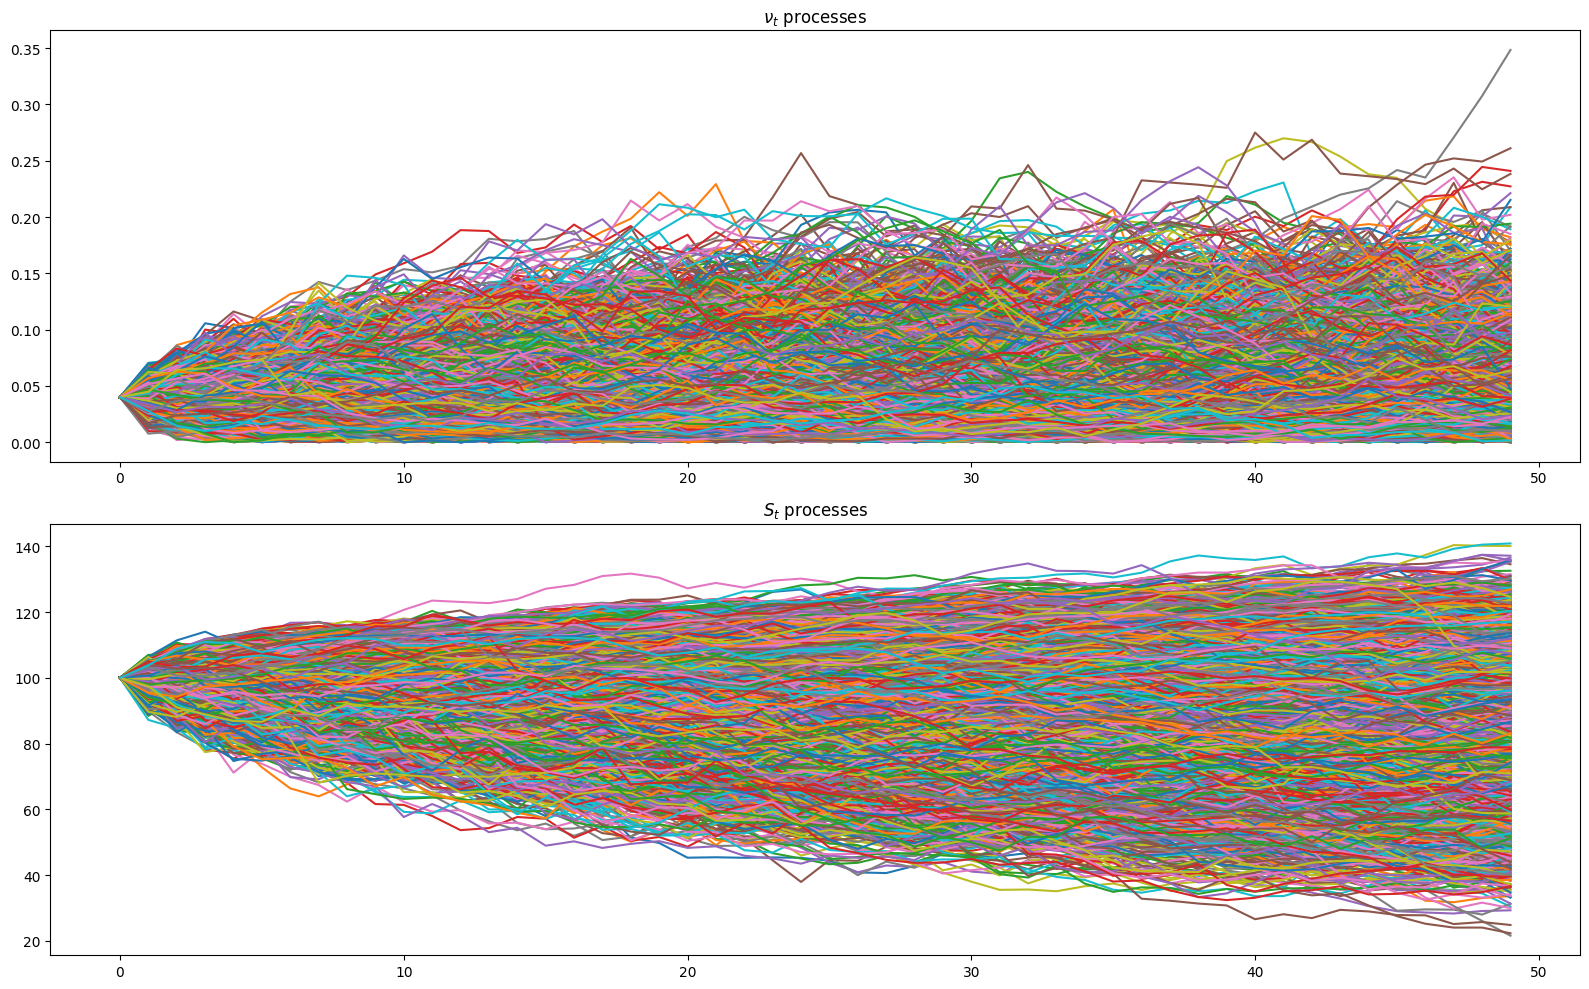

In [72]:
v0 = 0.04
kappa = 2
sigma = 0.3
theta = 0.04
rho = -0.9

S0 = 100  # Current underlying asset price
r = 0.05  # Risk-free rate
M0 = 50  # Number of time steps in a year
T = 1  # Number of years
n = int(M0 * T)  # Total time steps
M = 10000  # Number of simulations

# Simulate
v_MC, S_MC = MC(M, v0, kappa, theta, sigma, n, T, rho, r, S0)

print("S_MC =\n", S_MC)

fig, axs = plt.subplots(2, 1, figsize=(16, 10))
axs[0].plot(v_MC.T)
axs[0].set_title(r"$\nu_t$ processes")
axs[1].plot(S_MC.T)
axs[1].set_title("$S_t$ processes")
fig.tight_layout()

In [81]:
def heston_opt_price_MC(K, t, MC_params, call_or_put="C"):
    M, v0, kappa, theta, sigma, n, T, rho, r, S0 = MC_params
    v_MC, S_MC = MC(M, v0, kappa, theta, sigma, n, T, rho, r, S0)
    if call_or_put == "C":
        payoffs = np.maximum(0, S_MC[:, -1] - K)
    else:
        payoffs = np.maximum(0, K - S_MC[:, -1])
        
    return np.exp(-r * (T-t)) * payoffs.mean()

In [74]:
# MC params
v0 = 0.04
kappa = 2
sigma = 0.3
theta = 0.04
rho = -0.9
S0 = 100  # Current underlying asset price
r = 0.05  # Risk-free rate
M0 = 50  # Number of time steps in a year
T = 1  # Number of years
n = int(M0 * T)  # Total time steps
M = 10000  # Number of simulations

# Option params
K = 90
r = 0.05
t = 0

MC_params = [M, v0, kappa, theta, sigma, n, T, rho, r, S0]

call_price = heston_opt_price_MC(K, t, MC_params, "C")
print("call price =", call_price)

call price = 7.403404839011291


In [82]:
v0 = 0.05
kappa = 3
sigma = 0.25
theta = 0.02
rho = -0.25

S0 = 65  # Current underlying asset price
r = 0.05  # Risk-free rate
T = 3/12  # Number of years
n = 25
M = 10000  # Number of simulations

# Option params
K = 65
r = 0.05
t = 0

np.random.seed(42)

MC_params = [M, v0, kappa, theta, sigma, n, T, rho, r, S0]

put_price = heston_opt_price_MC(K, t, MC_params, "P")
print("put_price =", put_price)

put_price = 2.428086343476729


## **2. The Statistical Distribution Produced by Heston**

One important feature of the Heston model is that it produces a distribution of returns that has **heavier tails and kurtosis** than a normal distribution, just as we observe in practice.

In the following code snippet, we will check the Heston-produced distribution on two fronts:

1. Whether **underlying returns** resemble a Normal distribution, as assumed in BS and GBM process.

2. How **volatility** fits a mean-reverting process such as CIR or Vasicek.

_________________

# Merton Jump Diffusion Model

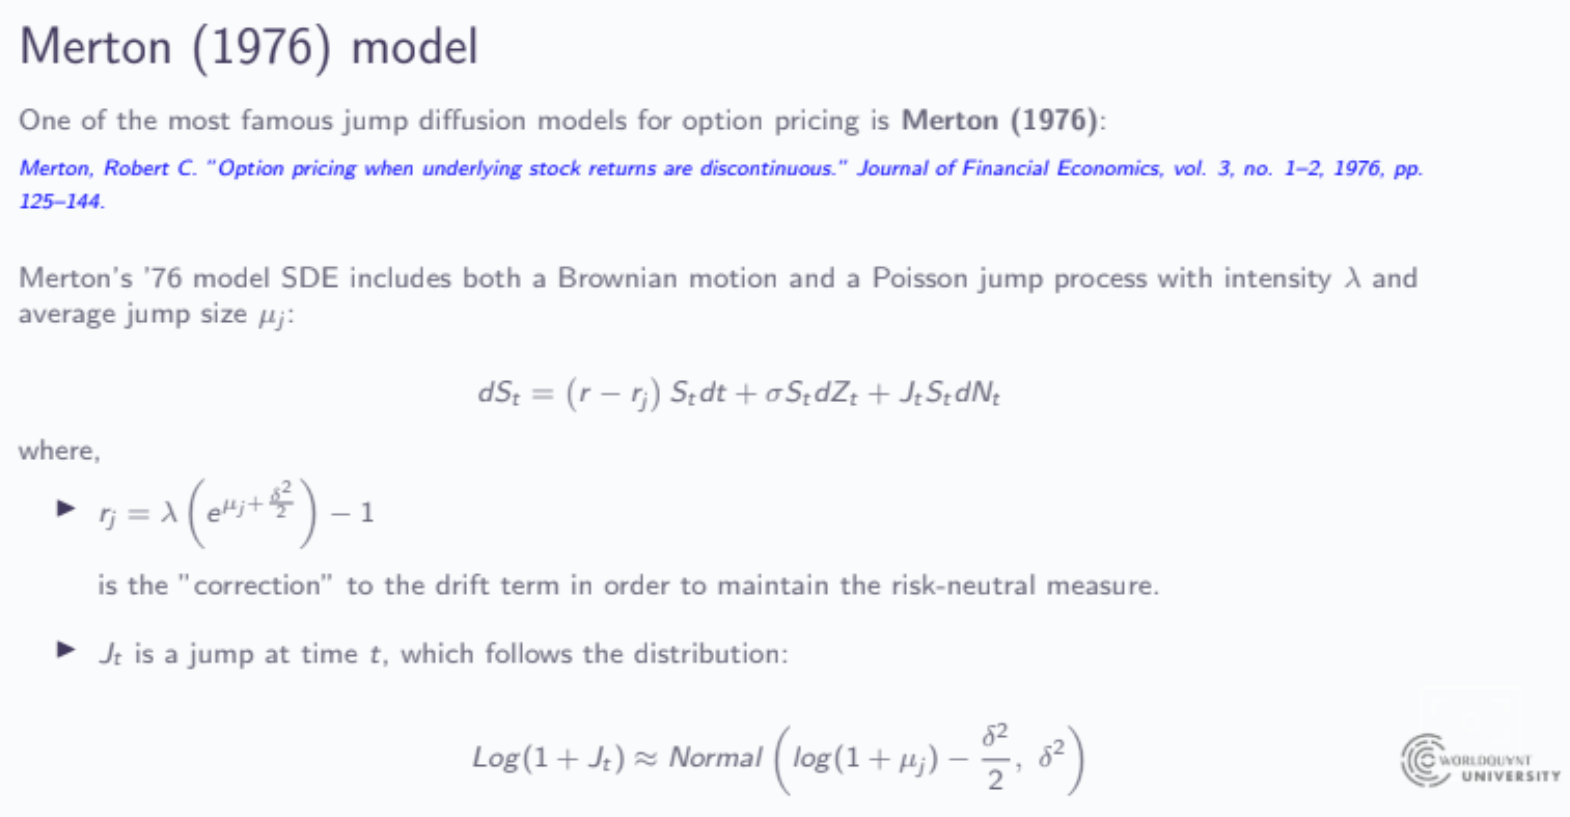

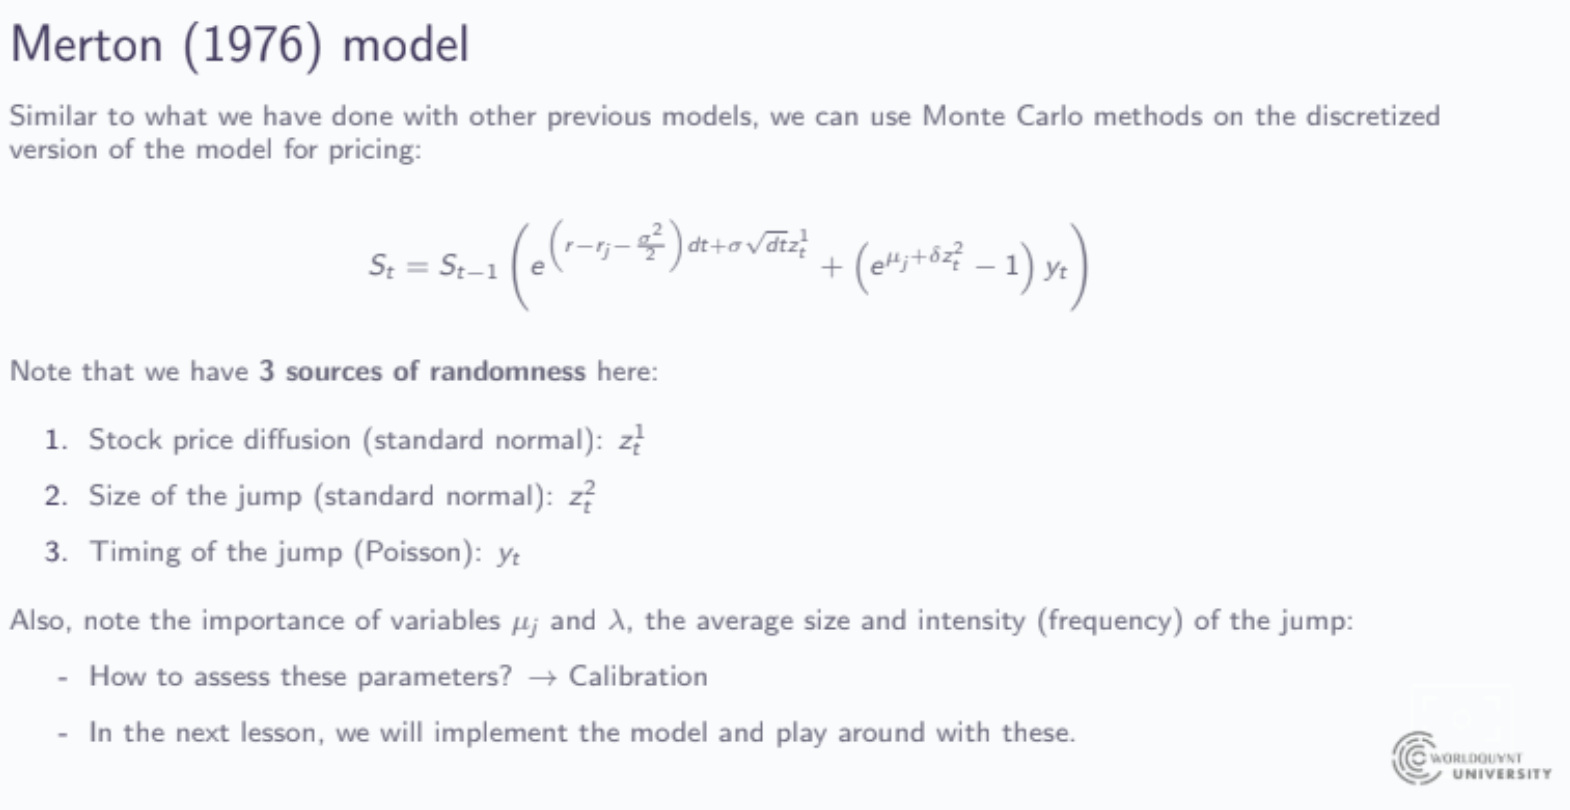

## 1. Implementing the Merton Model

We will start by implementing the Merton model in Python. As you already know, the model has the following SDE:

$$
\begin{equation*}
    \Large dS_t = \left( r - r_j \right) S_t dt + \sigma S_t dZ_t + J_t S_t dN_t
\end{equation*}
$$

with the following discretized form:

$$
\begin{equation*}
    \Large S_t = S_{t-1} \left( e^{\left(r-r_j-\frac{\sigma^2}{2}\right)dt + \sigma \sqrt{dt} z_t^1}+
    \left(e^{\mu_j+\delta z_t^2}-1 \right) y_t \right)
\end{equation*}
$$

where $z_t^1$ and $z_t^2$ follow a standard normal and $y_t$ follows a Poisson process. Finally, $r_j$ equals to:

$$
\begin{equation*}
\Large r_j = \lambda (\left(e^{\mu_j+\frac{\delta^2}{2}}\right)-1)
\end{equation*}
$$

Remember that, in order to obtain the parameters of the model, we will perform an exercise of calibration to option market prices. This will be, indeed, the first thing we will cover in the following Stochastic Modeling course. For now, let's assume these parameters as given and equal to:

# My Try

In [76]:
def S(lamb, mu, delta, r, sigma, T, S0, n):
    dt = T / n
    r_j = lamb * (np.exp(mu + delta**2 / 2) - 1)
    S_arr = np.zeros(n)
    S_arr[0] = S0
    for t in range(1, n):
        S_arr[t] = np.maximum(0.0001, (S_arr[t-1] * (np.exp((r - r_j - sigma**2 / 2)*dt + sigma*np.sqrt(dt)*np.random.standard_normal(1)) + (np.exp(mu + delta * np.random.standard_normal(1)) - 1)*np.random.poisson(lamb*dt, 1))))
    
    return S_arr

def merton_MC(M, lamb, mu, delta, r, sigma, T, S0, n):
    S_MC = np.zeros((M, n))  # each row is one path's time series
    for m in range(M):
        S_MC[m, :] = S(lamb, mu, delta, r, sigma, T, S0, n)
    
    return S_MC

C:\Users\adevr\AppData\Local\Temp\ipykernel_18224\3782676847.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_arr[t] = np.maximum(0.0001, (S_arr[t-1] * (np.exp((r - r_j - sigma**2 / 2)*dt + sigma*np.sqrt(dt)*np.random.standard_normal(1)) + (np.exp(mu + delta * np.random.standard_normal(1)) - 1)*np.random.poisson(lamb*dt, 1))))


 ...]

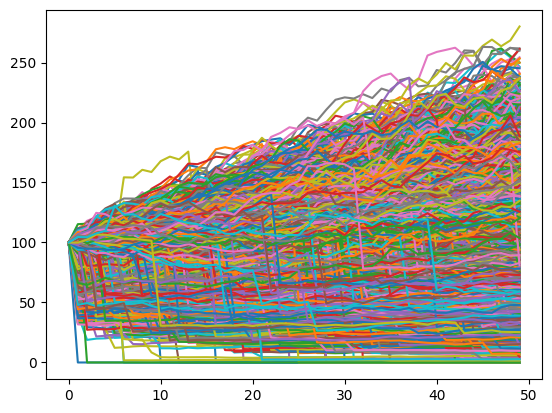

In [77]:
lamb = 0.75  # Lambda of the model
mu = -0.6  # Mu
delta = 0.25  # Delta

r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
T = 1.0  # Maturity/time period (in years)
S0 = 100  # Current Stock Price

M = 10000  # Number of simulations (paths)
n = 50  # Number of steps

merton_paramlist = [M, lamb, mu, delta, r, sigma, T, S0, n]

S_MC = merton_MC(M, lamb, mu, delta, r, sigma, T, S0, n)
plt.plot(S_MC.T)

In [78]:
def merton_opt_price_MC(merton_paramlist, K, t, call_or_put="C"):
    M, lamb, mu, delta, r, sigma, T, S0, n = merton_paramlist
    T_t = T - t
    S_MC = merton_MC(M, lamb, mu, delta, r, sigma, T_t, S0, n)
    if call_or_put == "C":
        payoffs = np.maximum(0, S_MC[:, -1] - K)
    else:
        payoffs = np.maximum(0, K - S_MC[:, -1])
    price = np.exp(-r * T_t) * payoffs.mean()
    
    return price
    
# call_price = merton_opt_price_MC(merton_paramlist, 90, 0, "C")
# print("Merton model call price =", call_price)

C:\Users\adevr\AppData\Local\Temp\ipykernel_18224\3782676847.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_arr[t] = np.maximum(0.0001, (S_arr[t-1] * (np.exp((r - r_j - sigma**2 / 2)*dt + sigma*np.sqrt(dt)*np.random.standard_normal(1)) + (np.exp(mu + delta * np.random.standard_normal(1)) - 1)*np.random.poisson(lamb*dt, 1))))


Merton model call price = 26.99535031499491


In [83]:
lamb = 0.0  # Lambda of the model
mu = 0.5  # Mu
delta = 0.75  # Delta

r = 0.05  # Risk-free rate
sigma = 0.45  # Volatility
T = 3/12  # Maturity/time period (in years)
S0 = 200  # Current Stock Price
K = 195

M = 10000  # Number of simulations (paths)
n = 50  # Number of steps

merton_paramlist = [M, lamb, mu, delta, r, sigma, T, S0, n]


call_price_merton = merton_opt_price_MC(merton_paramlist, K, 0, "C")
print("Merton model call price =", call_price_merton)

TypeError: S() takes 5 positional arguments but 8 were given